In [ ]:
import spacy

# Correct model name
nlp = spacy.load("en_core_web_sm")

x = """Hello, this is Thir from the like department. Who are you? I like apples."""

# Apply the model to the input text
doc = nlp(x)

# Print the index of each token
for token in doc:
    print(token.text)


Hello
,
this
is
Thir
from
the
like
department
.
Who
are
you
?
I
like
apples
.


In [ ]:
import nltk

# Download WordNet for lemmatization
nltk.download('wordnet')

# Download POS-tagged WordNet mapping (important for verbs/adjectives)
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer
lem=WordNetLemmatizer()
words=["going","eating","shipps","skipping","working","dying","slept","done","learnt","brought"]

for word in words:
    print(f"{word} --> {lem.lemmatize(word, pos='v')}")

going --> go
eating --> eat
shipps --> shipps
skipping --> skip
working --> work
dying --> die
slept --> sleep
done --> do
learnt --> learn
brought --> bring


In [1]:
!pip install kagglehub
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import kagglehub
path=kagglehub.dataset_download("imuhammad/us-2020-presidential-election-speeches")
print("Path to dataset files:", path)

100%|██████████| 2.99M/2.99M [00:00<00:00, 144MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/imuhammad/us-2020-presidential-election-speeches/versions/2


In [4]:
import os
files = os.listdir(path)
print("Files:",files)
import pandas as pd
csv_path = os.path.join(path,"us_2020_election_speeches.csv")
df = pd.read_csv(csv_path)
df.head()

Files: ['us_2020_election_speeches.csv']


,speaker,title,text,date,location,type
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...","Oct 15, 2020",ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,"Oct 15, 2020",NBC,Town Hall


In [5]:
text = df['text'][2]
print(text[:300])

President Trump: (00:30)
Thank you. What a nice group. Thank you very much. Beautiful, thank you.
Crowd: (00:50)
Four more years.
President Trump: (00:52)
Thank you very much, please. We are going to be talking to our great senior citizens, that’s what I’m here for today.
Speaker 1: (00:55)
[crossta


In [7]:
import spacy
nlp= spacy.load("en_core_web_sm")
doc = nlp(text)
processed_tokens = []
for token in doc:
    if not token.is_stop and not token.is_punct and not token.is_space:
        processed_tokens.append(token.lemma_)
cleaned_text = " ".join(processed_tokens)
print(cleaned_text[:500])

President Trump 00:30 thank nice group thank beautiful thank crowd 00:50 year President Trump 00:52 thank go talk great senior citizen today Speaker 1 00:55 crosstalk 00:00:50 President Trump 00:56 love senior citizen honor Fort Myers reaffirm solemn pledge America senior important happen senior protect defend fight ounce energy conviction devote life country devote life administration work day amazing senior citizen care support respect deserve understand work long time president deeply aware A


In [12]:
#to remove the timestamps we need to use the regex which is regular expression bf passing to do the spacy
import re
cleaned = re.sub(r'\b\d{1,2}:\d{2}(?::\d{2})?\b', '', text)  # to remove the timestamps
cleaned = re.sub(r'(President Trump)', '', cleaned)
cleaned = re.sub(r'\s+', ' ', cleaned).strip()   #strip is to remove the leading and tailing spaces since it was a list
import spacy
nlp= spacy.load("en_core_web_sm")
doc = nlp(cleaned)
processed_tokens = []
for token in doc:
    if not token.is_stop and not token.is_punct and not token.is_space:
        processed_tokens.append(token.lemma_)
cleaned_text = " ".join(processed_tokens)
print(cleaned_text[:500])

thank nice group thank beautiful thank crowd year thank go talk great senior citizen today Speaker 1 crosstalk love senior citizen honor Fort Myers reaffirm solemn pledge America senior important happen senior protect defend fight ounce energy conviction devote life country devote life administration work day amazing senior citizen care support respect deserve understand work long time president deeply aware America 54 million senior bear heavy burden China virus old Americans endure month isola


In [10]:
import re
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from collections import deque

# Text preprocessing functions
def clean_text_spacing(text):
    #print("\n[Step 1.1] OG Text:\n", text[:500], "...")
    text = re.sub(r'(?<=[.!?])(?=\w)', r' ', text)
    text = re.sub(r'(?<=[.,!?;:])(?=\S)', r' ', text)
   # print("\n[Step 1.2] After Cleaned Text (Spacing Fixed):\n", text[:500], "...")
    return text

def split_into_sentences(text):
    sentence_endings = re.compile(r'(?<=[.!?])\s+(?=[A-Z])')
    return sentence_endings.split(text)

# Load sample text
text_test = """Baking apple pie? Discount orange warehouse has you covered! A fruit’s a fruit, right?It’s 1988, and scientist James Hansen  has just testified to the United States Congress  that global warming trends are caused by human activity, and will pose an increasing threat  to humanity in the future.Well, well.  That’s unusually prescient for a human.Looking for a wedding dress? Try a new take on a timeless classic. It’s sleek, flattering and modest—  just like the traditional dress.Commercials. Could anything be more insufferable?It’s 1997, and the United States Senate  has called a hearing about global warming. Some expert witnesses point out that  past periods in Earth’s history were warmer than the 20th century. Because such variations existed long before humans, the witnesses claim the current warming trend is also the result of natural variation.Ah, there is something more insufferable than a commercial. Luckily for the humans,  there’s one more expert witness.What are you looking at?  We’re all dressed. At least we are by the logic  you just used. It’s as if you were to say  apples and oranges are both fruits, therefore they taste the same. Or that underwear, wedding dresses,  and suits are all clothes, therefore, they’re all equally appropriate attire for a Senate hearing.The European wars of the 19th century  and World War I were all wars, right?So World War I couldn’t be any more devastating than those other wars, could it?Let’s say two people have a fever. They must have the same disease  that’s causing that fever, right?Of course not.  One fever could be caused by chicken pox, the other by influenza,  or any number of other infections. Like your claim about rising global temperatures, these claims make a false analogy. You're assuming that because two phenomena share a characteristic, in this case warming,  they are analogous in other ways, like the cause of that warming.But there’s no evidence  that that’s the case. Yes, there have been other warm periods  in Earth’s history— no one’s disputing that the climate  fluctuates. But let's take a closer look at some of those older examples of global warming, shall we?The Cretaceous Hot Greenhouse, 92 million years ago, was so warm,  forests covered Antarctica. Volcanic activity was likely responsible for boosting atmospheric carbon dioxide and creating a greenhouse effect.The Paleocene-Eocene Thermal Maximum,  55 million years ago, was so warm, crocodiles swam the waters of the Arctic Circle. This warming may have been caused by the drying of inland seas and release of methane,  a potent greenhouse gas, from ocean sediments,Even among these other warm periods, you’re making a false analogy. Yes, they had natural causes. But each had a different cause, and involved a different amount  and duration of warming. They’re as dissimilar as they are similar. Taking them together,  all we can reasonably conclude is that the Earth’s climate  seems to change in response to conditions on the planet.Today, human activity is a dominant force shaping conditions on your planet, so the possibility that it’s driving global warming can’t be dismissed out of hand. I’ll grant that the more complicated  something is, the easier it is to make a mistaken analogy. That’s especially true because there are many different types of false analogy: that similar symptoms must share a cause, that similar actions must lead to similar consequences, and countless others. Most false analogies you’ll come  across are far less obvious than those comparing apples to oranges,  and climate is notoriously complex. It requires careful, rigorous study and evidence collection— and making a false analogy like this only impedes that process.It’s 2013, and the United Nations Intergovernmental Panel on Climate Change has found,  aggregating decades of research, that there is more than a 95% chance  the global warming trend since the mid-20th century  has been driven by human activity, namely the burning of fossil fuels.You’re both pets, and he likes living in water, so you should, too."""
cleaned_text = clean_text_spacing(text_test)
sentences = split_into_sentences(cleaned_text)

# Initialize model
#print("\n[Step 3] Loading model...")
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')


#print("\n[Step 4] Encoding sentences into embeddings...")
#sent_embed = model.encode(sentences, convert_to_tensor=True)
#print("Done! Shape of embeddings:", sent_embed.shape)///

#print("\n[Sample Embedding Vectors (first 2 sentences)]:")
#for i in range(min(2, len(sentences))):
  ##  print(f"Sentence {i+1}: {sentences[i]}")
#print(f"Embedding {i+1} (dim {sent_embed[i].shape[0]}):")
  #  print(sent_embed[i][:10])  # Print first 10 values


Processing speech and predicting completion:

Batch  | Topics | Novelty | Staleness | Completion | Status
----------------------------------------------------------------------
1      | 5      | 1.0000  | 0.0000    |    0.0%    | [                    ]
         └─ New: 5, Reused: 0, Threshold: 0.750
2      | 5      | 1.0000  | 0.0000    |   11.1%    | [==                  ]
         └─ New: 5, Reused: 0, Threshold: 0.713
3      | 4      | 0.9268  | 0.1831    |   12.6%    | [==                  ]
         └─ New: 3, Reused: 1, Threshold: 0.679
4      | 5      | 1.0000  | 0.0000    |   15.2%    | [===                 ]
         └─ New: 5, Reused: 0, Threshold: 0.646
5      | 4      | 1.0000  | 0.0000    |   19.0%    | [===                 ]
         └─ New: 4, Reused: 0, Threshold: 0.614
6      | 4      | 0.9268  | 0.1831    |   24.1%    | [====                ]
         └─ New: 3, Reused: 1, Threshold: 0.584
7      | 3      | 0.7182  | 0.7044    |   33.8%    | [======              ]
   

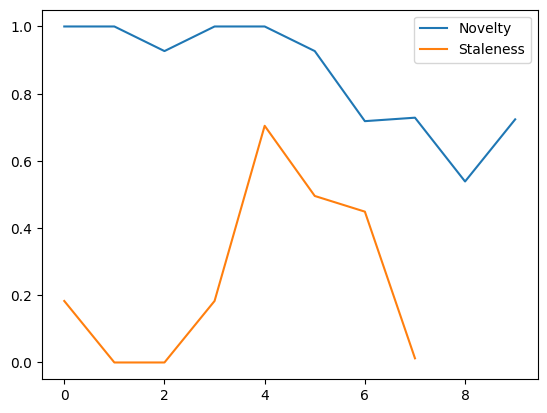

In [12]:
class TopicTracker:
    def __init__(self, novelty_decay=0.2, staleness_threshold=0.65,initial_threshold=0.75, decay_rate=0.05, min_threshold=0.45):
        self.topics = {}  # topic_id: {'centroid', 'last_seen', 'count'}
        self.next_topic_id = 0
        self.novelty_decay = novelty_decay
        self.staleness_threshold = staleness_threshold
        self.novelty_history = deque(maxlen=10)
        self.staleness_history = deque(maxlen=10)

        # Adaptive threshold
        self.initial_threshold = initial_threshold
        self.decay_rate = decay_rate
        self.min_threshold = min_threshold

        #Changing the threshold
    def get_dynamic_threshold(self, batch_index):
      threshold = self.initial_threshold * np.exp(-self.decay_rate * batch_index)

      return max(threshold, self.min_threshold)


    def update_topics(self, batch_embeddings,batch_index):
        """Cluster sentences and update topic registry"""
        # Convert to numpy for clustering
        embeddings_np = batch_embeddings.cpu().numpy() if isinstance(batch_embeddings, torch.Tensor) else batch_embeddings

        # Cluster using DBSCAN
        clustering = DBSCAN(eps=0.4, min_samples=1, metric='cosine').fit(embeddings_np)
        labels = clustering.labels_

        # Process clusters
        batch_topics = {}
        threshold = self.get_dynamic_threshold(batch_index)
        for label in set(labels):
            if label == -1:  # Handle noise as individual topics ie the as the new ones
                for i in np.where(labels == label)[0]:
                    topic_centroid = embeddings_np[i]
                    topic_id = self._match_or_create_topic(topic_centroid,threshold)
                    batch_topics[topic_id] = batch_topics.get(topic_id, []) + [i]
            #if not the noise
            else:
                indices = np.where(labels == label)[0]
                topic_centroid = np.mean(embeddings_np[indices], axis=0)
                topic_id = self._match_or_create_topic(topic_centroid,threshold)
                batch_topics[topic_id] = batch_topics.get(topic_id, []) + list(indices)

        return batch_topics

    def _match_or_create_topic(self, centroid,threshold):
        """Match to existing topic or create new one"""
        best_match = None
        best_sim = -1

        for topic_id, topic_data in self.topics.items():
            sim = 1 - distance.cosine(centroid, topic_data['centroid'])
            if sim > best_sim:
                best_sim = sim
                best_match = topic_id

        # Update existing topic or create new
        if best_sim >threshold:
            self.topics[best_match]['centroid'] = (
                self.topics[best_match]['centroid'] + centroid  #prev+new/2
            ) / 2
            self.topics[best_match]['count'] += 1
            self.topics[best_match]['last_seen'] = len(self.novelty_history)
            return best_match
        else:
            self.topics[self.next_topic_id] = {
                'centroid': centroid,
                'last_seen': len(self.novelty_history),
                'count': 1
            }
            self.next_topic_id += 1
            return self.next_topic_id - 1

    def calculate_novelty(self, batch_topics):
        """Calculate novelty score for current batch"""
        if not batch_topics:
            return 0.0

        novelty = 0
        for topic_id in batch_topics:
            topic_data = self.topics[topic_id]
            # Calculate decay based on how many batches since last seen
            if 'last_seen' in topic_data:
                batches_ago = len(self.novelty_history) - topic_data['last_seen']
                decay_factor = np.exp(-self.novelty_decay * batches_ago)
            else:
                decay_factor = 1.0  # New topic

            # Higher novelty for topics seen fewer times
            novelty += decay_factor / (topic_data['count'] ** 0.5)

        # Normalize by number of topics
        normalized_novelty = novelty / len(batch_topics)
        self.novelty_history.append(normalized_novelty)
        return normalized_novelty

    def calculate_staleness(self):
        """Calculate staleness based on novelty trend"""
        if len(self.novelty_history) < 3:
            return 0.0

        # Calculate trend of last 3 novelty scores
        recent_novelty = list(self.novelty_history)[-3:]
        x = np.arange(3)
        slope, _ = np.polyfit(x, recent_novelty, 1)

        # Staleness increases when novelty decreases
        staleness = max(0, -slope * 5)  # Scale slope to [0,1] range
        self.staleness_history.append(staleness)
        return min(1.0, staleness)

    def detect_closing_phrases(self, sentences):
        """Detect closing phrases in text"""
        closing_indicators = [
            "in conclusion", "to summarize", "finally", "lastly",
            "in summary", "to wrap up", "closing thoughts", "thank you",
            "i enjoyed our conversation", "that's all", "we've covered"
        ]

        for sentence in sentences:
            if any(phrase in sentence.lower() for phrase in closing_indicators):
                return 1.0
        return 0.0

    def predict_completion(self, current_batch_index, total_batches, sentences):
        """Predict completion percentage"""
        if len(self.novelty_history) < 3:
            # Not enough data, use position-based estimate
            position_ratio = current_batch_index / total_batches if total_batches > 0 else 0
            return min(90, position_ratio * 100)

        # Position-based completion
        position_ratio = current_batch_index / total_batches

        # Novelty decay factor
        recent_novelty = np.mean(list(self.novelty_history)[-3:])
        initial_novelty = np.mean(list(self.novelty_history)[:3])
        novelty_decay = max(0, 1 - (recent_novelty / initial_novelty)) if initial_novelty > 0 else 0

        # Staleness factor
        staleness = np.mean(self.staleness_history) if self.staleness_history else 0

        # Closing phrases detection
        closing_score = self.detect_closing_phrases(sentences)

        # Combine factors with weights
        completion = (
            0.4 * position_ratio +
            0.3 * novelty_decay +
            0.2 * staleness +
            0.1 * closing_score
        )

        return min(99, completion * 100)

# Process text in batches
BATCH_SIZE = 5
tracker = TopicTracker()

print("Processing speech and predicting completion:\n")
print(f"{'Batch':<6} | {'Topics':<6} | {'Novelty':<7} | {'Staleness':<9} | {'Completion':<10} | Status")
print("-" * 70)

for batch_idx in range(0, len(sentences), BATCH_SIZE):
    batch_sentences = sentences[batch_idx:batch_idx+BATCH_SIZE]
    batch_embeddings = model.encode(batch_sentences, convert_to_tensor=True)

    # Update topics and calculate novelty
    batch_topics = tracker.update_topics(batch_embeddings,batch_idx // BATCH_SIZE)

    new_topics = 0
    reused_topics = 0
    for topic_id in batch_topics:
        if tracker.topics[topic_id]['count'] == 1:
            new_topics += 1
        else:
            reused_topics += 1

    # Get dynamic threshold used
    threshold_used = tracker.get_dynamic_threshold(batch_idx // BATCH_SIZE)


    novelty = tracker.calculate_novelty(batch_topics)
    staleness = tracker.calculate_staleness()

    # Predict completion percentage
    completion = tracker.predict_completion(
        batch_idx // BATCH_SIZE,
        len(sentences) // BATCH_SIZE,
        batch_sentences
    )

    # Visual progress bar
    progress_bar = "[" + "=" * int(completion / 5) + " " * (20 - int(completion / 5)) + "]"

    print(f"{batch_idx//BATCH_SIZE+1:<6} | {len(batch_topics):<6} | {novelty:.4f}  | {staleness:.4f}    | {completion:6.1f}%    | {progress_bar}")
    print(f"         └─ New: {new_topics}, Reused: {reused_topics}, Threshold: {threshold_used:.3f}")


    #print(f"{batch_idx//BATCH_SIZE+1:<6} | {len(batch_topics):<6} | {novelty:.4f}  | {staleness:.4f}    | {completion:6.1f}%    | {progress_bar}")

    # Early exit if completion is high
    if completion > 90:
        print("\n[!] Speech completion predicted - ending analysis")
        break

# Final topic analysis
print("\nTopic Summary:")
for topic_id, topic_data in tracker.topics.items():
    print(f"Topic {topic_id}: Seen {topic_data['count']} times")

import matplotlib.pyplot as plt

plt.plot(tracker.novelty_history, label='Novelty')
plt.plot(tracker.staleness_history, label='Staleness')
plt.legend()
plt.show()

